In [414]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

VINA = False  # set this to True or False

data_dirs = ["../Data/other/SDF poses"]

data = []

for sdf_dir in data_dirs:
    for filename in os.listdir(sdf_dir):
        if filename.endswith(".sdf"):
            name = filename[:-4]
            if not VINA and "VINA" in name:
                continue  # skip VINA poses if VINA=False
            sdf_path = os.path.join(sdf_dir, filename)
            suppl = Chem.SDMolSupplier(sdf_path)
            for mol in suppl:
                if mol:
                    smiles = Chem.MolToSmiles(mol)
                    data.append({
                        "name": name,
                        "smiles": smiles,
                        "source": os.path.basename(sdf_dir)
                    })

df = pd.DataFrame(data)
PandasTools.AddMoleculeColumnToFrame(frame=df, smilesCol='smiles')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    31 non-null     object
 1   smiles  31 non-null     object
 2   source  31 non-null     object
 3   ROMol   31 non-null     object
dtypes: object(4)
memory usage: 1.1+ KB


In [415]:
# load from csv if it exists
csv_path = "../Data/docs/8.PLIP_poses.csv"
df_plip = pd.read_csv(csv_path)

# rename Pose_ID to name
df_plip.rename(columns={"Pose_ID": "name"}, inplace=True)

# merge with the main dataframe
df = pd.merge(df, df_plip, on='name', how='left')
df.head()

,name,smiles,source,ROMol,hbondd_HIS_268_A,hydroph_PHE_267_A,hydroph_LEU_328_A,hydroph_ASP_339_A,hydroph_LYS_196_A,hydroph_VAL_204_A,...,hbondd_ARG_198_A,hbonda_SER_272_A,saltbridge_GLU_230_A,hbondd_THR_265_A,hbonda_ASP_321_A,hbonda_ARG_198_A,hbondd_ARG_200_A,hbondd_LYS_217_A,saltbridge_GLU_194_A,hydroph_GLU_194_A
0,B4B_5OXG,c1cc(-c2cnn3cc(-c4ccc(N5CCNCC5)cc4)cnc23)c2ccc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x32698cf90>,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,C9U_6JUX,CCn1cc(-c2ccnc(Nc3ccc(N4CCNCC4)cc3)n2)c(-c2ccc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x32698c6d0>,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,H8H_6ZGC,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x32698d150>,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,XQX_8UWR,O=C(C1CC1)N1CCN(c2ccnn3cc(-c4ccc(N5CCNCC5)cc4)...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x32698c9e0>,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,LDN_3Q4U,c1ccc2c(-c3cnn4cc(-c5ccc(N6CCNCC6)cc5)cnc34)cc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x32698f760>,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


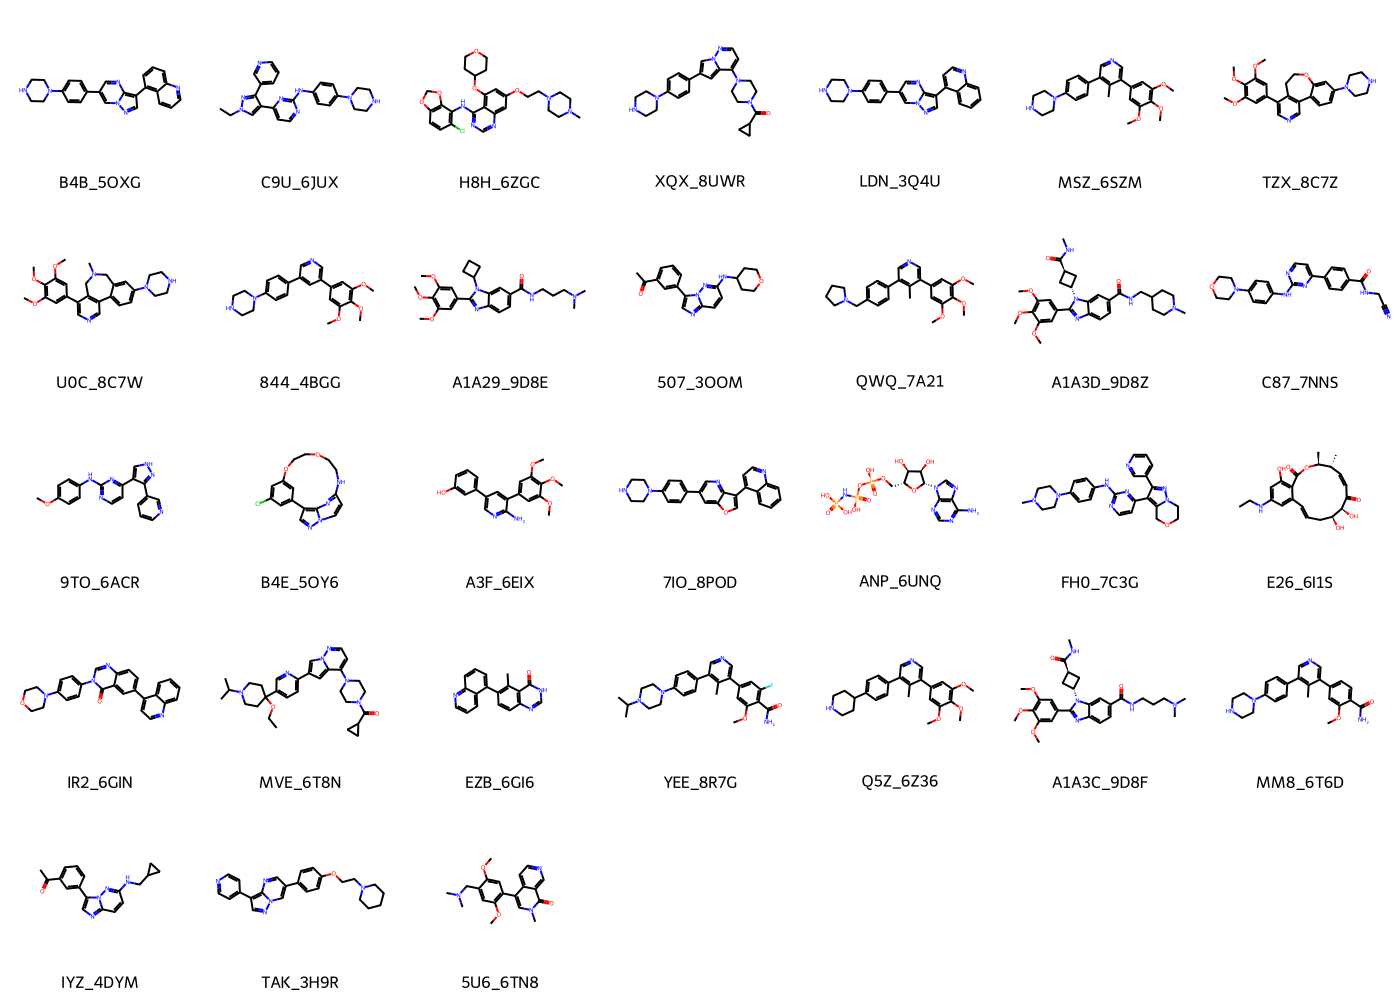

In [416]:
from rdkit.Chem import Draw

# Draw first 10 molecules
names = df['name'].tolist()
mols = [Chem.MolFromSmiles(smiles) for smiles in df['smiles']]
img = Draw.MolsToGridImage(mols, molsPerRow=7, subImgSize=(200,200), legends=names)
img

In [ ]:
with open("../Results/images/Pharmacophore compounds.png", "wb") as png:
    png.write(img.data)

In [417]:
from rdkit.Chem import AllChem

def morgan_fp(mol):
    morgan = AllChem.GetMorganGenerator(radius=2, fpSize=512)
    return morgan.GetFingerprint(mol)

df['morgan'] = df['ROMol'].apply(morgan_fp)

In [418]:
from rdkit import DataStructs

def matrix_Tanimoto(mols):
    matrix = []

    for mol in mols:
        array_similaridade = DataStructs.BulkTanimotoSimilarity(mol, mols)
        matrix.append(array_similaridade)

    return pd.DataFrame(data=matrix)

tanimoto = matrix_Tanimoto(df['morgan'])
tanimoto

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.000000,0.350000,0.148515,0.400000,0.882353,0.343284,0.293333,0.302632,0.380952,0.103093,...,0.333333,0.233333,0.318182,0.238095,0.200000,0.108911,0.315068,0.195122,0.357143,0.119048
1,0.350000,1.000000,0.135135,0.317073,0.358974,0.298701,0.258824,0.297619,0.328767,0.147059,...,0.232558,0.273684,0.154762,0.212766,0.176471,0.140187,0.292683,0.227273,0.220930,0.142857
2,0.148515,0.135135,1.000000,0.126214,0.140000,0.125000,0.173469,0.135922,0.141304,0.179245,...,0.163265,0.151786,0.117021,0.129630,0.125000,0.160714,0.128713,0.160000,0.241758,0.154639
3,0.400000,0.317073,0.126214,1.000000,0.411765,0.343284,0.310811,0.253165,0.380952,0.163043,...,0.263158,0.585714,0.129870,0.268293,0.232877,0.166667,0.371429,0.225000,0.217949,0.146341
4,0.882353,0.358974,0.140000,0.411765,1.000000,0.353846,0.301370,0.310811,0.393443,0.117021,...,0.382353,0.238636,0.250000,0.243902,0.205479,0.122449,0.323944,0.185185,0.367647,0.121951
5,0.343284,0.298701,0.125000,0.343284,0.353846,1.000000,0.648148,0.596491,0.717391,0.269231,...,0.257143,0.211765,0.161765,0.573770,0.640000,0.268293,0.760000,0.184211,0.191781,0.228571
6,0.293333,0.258824,0.173469,0.310811,0.301370,0.648148,1.000000,0.689655,0.563636,0.261905,...,0.250000,0.222222,0.146667,0.391892,0.459016,0.247191,0.507937,0.212500,0.146341,0.256757
7,0.302632,0.297619,0.135922,0.253165,0.310811,0.596491,0.689655,1.000000,0.543860,0.213483,...,0.212500,0.166667,0.157895,0.363636,0.400000,0.202128,0.469697,0.178571,0.170732,0.217949
8,0.380952,0.328767,0.141304,0.380952,0.393443,0.717391,0.563636,0.543860,1.000000,0.246753,...,0.250000,0.234568,0.134328,0.409091,0.436364,0.246914,0.574074,0.208333,0.200000,0.220588
9,0.103093,0.147059,0.179245,0.163043,0.117021,0.269231,0.261905,0.213483,0.246753,1.000000,...,0.153846,0.188119,0.116279,0.241758,0.302632,0.779412,0.265060,0.215909,0.130435,0.256098


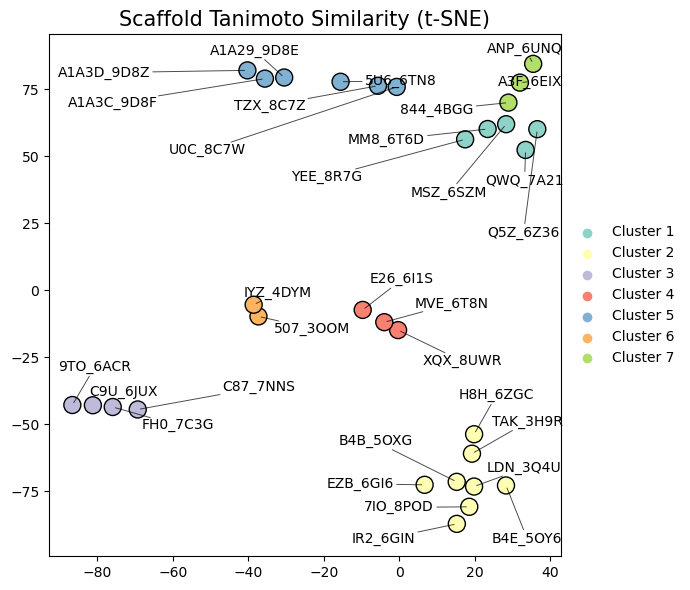

Silhouette score: 0.65434176


In [406]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.metrics import silhouette_score

tsne = TSNE(metric='precomputed', init='random', random_state=42, perplexity=2)
embedding_tsne = tsne.fit_transform(1 - tanimoto)

kmeans = KMeans(n_clusters=7, random_state=42)
labels_TSNE = kmeans.fit_predict(embedding_tsne)

cmap = plt.get_cmap('Set3')

plt.figure(figsize=(7, 6))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=cmap(labels_TSNE), s=150, edgecolor="black")
plt.title('Scaffold Tanimoto Similarity (t-SNE)', fontsize=15)

texts = [plt.text(embedding_tsne[i, 0], embedding_tsne[i, 1], name, fontsize=10, alpha=1)
        for i, name in enumerate(df['name'])]
adjust_text(texts, arrowprops=dict(arrowstyle='-', alpha=0.7, color='black', lw=0.7), force_text=1, force_static=1, prevent_crossings=True, ensure_inside_axes=True, expand=(2,1.5))


for i in range(7):
    plt.scatter([], [], color=cmap(i), label=f'Cluster {i+1}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=10)
plt.tight_layout()
plt.savefig("../Results/images/Scaffold clusters T-SNE (no Vina).png", dpi=300)
plt.show()

score = silhouette_score(embedding_tsne, labels_TSNE)
print(f'Silhouette score:', score)

/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,name,smiles,source,ROMol,hbondd_HIS_268_A,hydroph_PHE_267_A,hydroph_LEU_328_A,hydroph_ASP_339_A,hydroph_LYS_196_A,hydroph_VAL_204_A,...,hbonda_SER_272_A,saltbridge_GLU_230_A,hbondd_THR_265_A,hbonda_ASP_321_A,hbonda_ARG_198_A,hbondd_ARG_200_A,hbondd_LYS_217_A,saltbridge_GLU_194_A,hydroph_GLU_194_A,cluster
0,B4B_5OXG,c1cc(-c2cnn3cc(-c4ccc(N5CCNCC5)cc4)cnc23)c2ccc...,SDF poses,,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,2
1,C9U_6JUX,CCn1cc(-c2ccnc(Nc3ccc(N4CCNCC4)cc3)n2)c(-c2ccc...,SDF poses,,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,3
2,H8H_6ZGC,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,SDF poses,,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,2
3,XQX_8UWR,O=C(C1CC1)N1CCN(c2ccnn3cc(-c4ccc(N5CCNCC5)cc4)...,SDF poses,,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,4
4,LDN_3Q4U,c1ccc2c(-c3cnn4cc(-c5ccc(N6CCNCC6)cc5)cnc34)cc...,SDF poses,,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,2
5,MSZ_6SZM,COc1cc(-c2cncc(-c3ccc(N4CCNCC4)cc3)c2C)cc(OC)c1OC,SDF poses,,True,True,False,False,True,True,...,False,False,False,False,False,False,False,False,False,1
6,TZX_8C7Z,COc1cc(-c2cncc3c2CCOc2cc(N4CCNCC4)ccc2-3)cc(OC...,SDF poses,,True,True,False,False,True,True,...,False,False,False,False,False,False,False,False,False,5
7,U0C_8C7W,COc1cc(-c2cncc3c2CN(C)Cc2cc(N4CCNCC4)ccc2-3)cc...,SDF poses,,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,5
8,844_4BGG,COc1cc(-c2cncc(-c3ccc(N4CCNCC4)cc3)c2)cc(OC)c1OC,SDF poses,,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,7
9,A1A29_9D8E,COc1cc(-c2nc3ccc(C(=O)NCCCN(C)C)cc3n2C2CCC2)cc...,SDF poses,,False,True,False,False,True,True,...,False,False,False,False,False,False,False,False,False,5

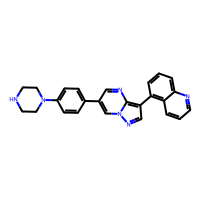
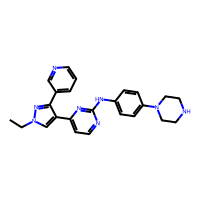
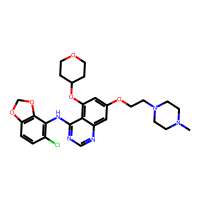
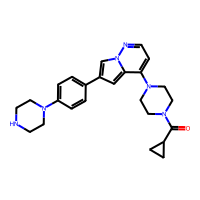
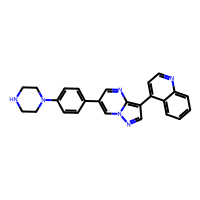
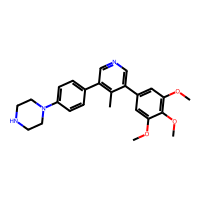
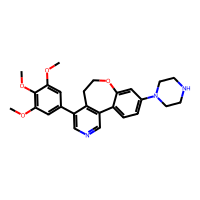
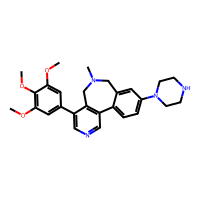
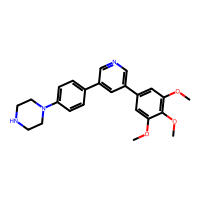
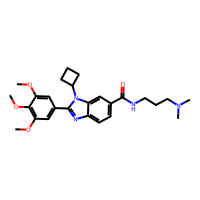
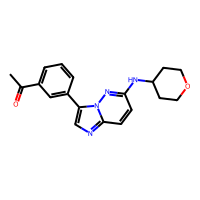
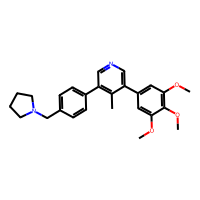
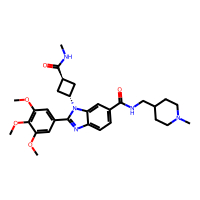
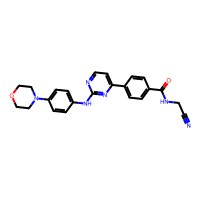
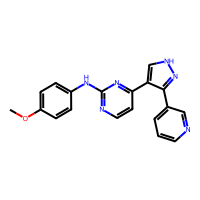
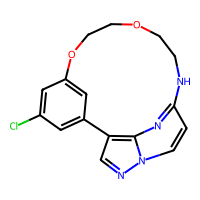
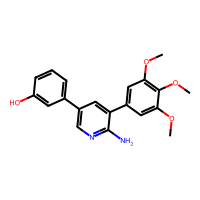
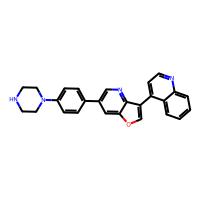
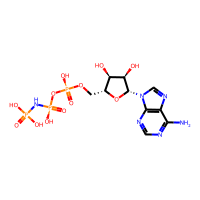
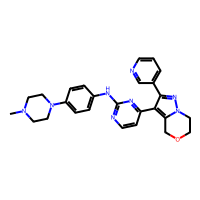
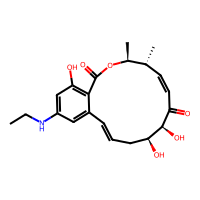
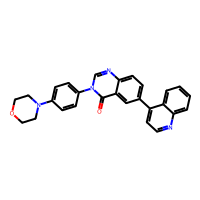
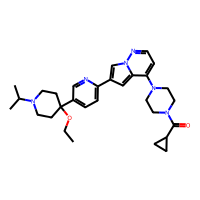
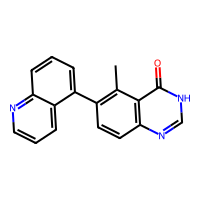
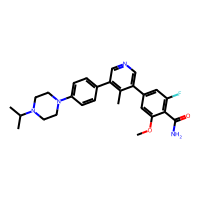
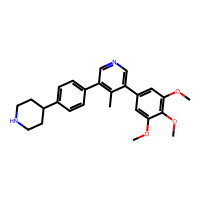
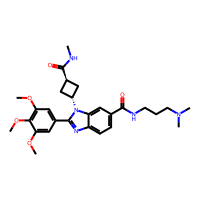
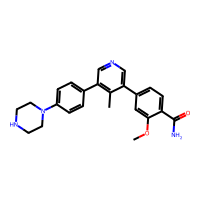
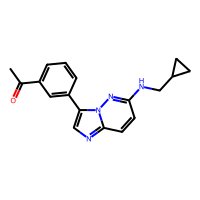
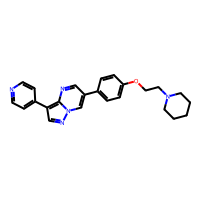
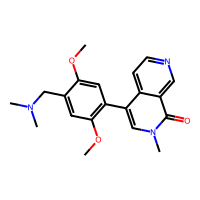

In [407]:
df_clusters = df.copy()
df_clusters['cluster'] = labels_TSNE
df_clusters['cluster'] = df_clusters['cluster'] + 1  # make sure all clusters are +1 to lign up with the UMAP plot
df_clusters = df_clusters.drop(columns=['morgan'])

# filter cluster column to only show 1 and 5
#df_clusters = df_clusters[df_clusters['cluster'].isin([1])].reset_index(drop=True)
PandasTools.AddMoleculeColumnToFrame(frame=df_clusters, smilesCol='smiles')
df_clusters

In [ ]:
# store pharmacophores based on clusters
import os
import shutil
import pandas as pd

# Directory containing the JSON files
json_dir = "../Results/pharmacophores"  # replace with actual path

# Ensure cluster folders exist and move files
for _, row in df_clusters.iterrows():
    cluster = row['cluster']
    name_prefix = row['name'][:4]  # first 3-4 characters
    cluster_folder = os.path.join(json_dir, f"cluster_{cluster}")
    os.makedirs(cluster_folder, exist_ok=True)

    # Find and move matching json files
    for file in os.listdir(json_dir):
        if file.endswith(".json") and file.startswith(name_prefix):
            src = os.path.join(json_dir, file)
            dst = os.path.join(cluster_folder, file)
            shutil.move(src, dst)


/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


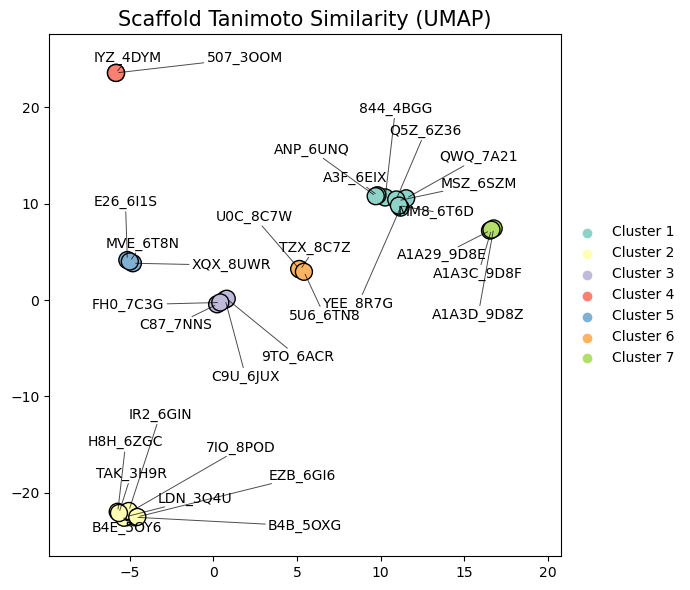

Silhouette score: 0.93024135


In [419]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score

# Assuming your matrix is in a DataFrame called df
reducer = umap.UMAP(metric='precomputed', n_neighbors=2, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(1 - tanimoto)  # 1 - similarity = distance

kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(embedding)

cmap = plt.get_cmap('Set3')  # discrete colormap
colors = cmap(labels)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=150, edgecolor="black")

# Add labels for each molecule (replace molecule_names with your list)
texts = [plt.text(embedding[i, 0], embedding[i, 1], name, fontsize=10, alpha=1)
        for i, name in enumerate(df['name'])]
adjust_text(texts, arrowprops=dict(arrowstyle='-', alpha=0.7, color='black', lw=0.7), force_text=1, force_static=1, prevent_crossings=True, ensure_inside_axes=True, expand=(2,1.5))

for i in range(7):
    plt.scatter([], [], color=cmap(i), label=f'Cluster {i+1}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=10)
plt.title('Scaffold Tanimoto Similarity (UMAP)', fontsize=15)
plt.xlim(embedding[:, 0].min() - 4, embedding[:, 0].max() + 4)
plt.ylim(embedding[:, 1].min() - 4, embedding[:, 1].max() + 4)
plt.tight_layout()
plt.savefig("../Results/images/scaffold clusters UMAP (no Vina).png", dpi=300)
plt.show()

score = silhouette_score(embedding, labels)
print(f'Silhouette score:', score)

In [422]:
df_clusters = df.copy()
df_clusters['cluster'] = labels
df_clusters['cluster'] = df_clusters['cluster'] + 1  # make sure all clusters are +1 to lign up with the UMAP plot
df_clusters = df_clusters.drop(columns=['morgan'])

# filter cluster column to only show 1 and 5
#df_clusters = df_clusters[df_clusters['cluster'].isin([3])].reset_index(drop=True)
PandasTools.AddMoleculeColumnToFrame(frame=df_clusters, smilesCol='smiles')
#save the dataframe to a CSV file
df_clusters.to_csv("../Data/docs/10.clean_clusters.csv", index=False)
df_clusters.head()

,name,smiles,source,ROMol,hbondd_HIS_268_A,hydroph_PHE_267_A,hydroph_LEU_328_A,hydroph_ASP_339_A,hydroph_LYS_196_A,hydroph_VAL_204_A,...,hbonda_SER_272_A,saltbridge_GLU_230_A,hbondd_THR_265_A,hbonda_ASP_321_A,hbonda_ARG_198_A,hbondd_ARG_200_A,hbondd_LYS_217_A,saltbridge_GLU_194_A,hydroph_GLU_194_A,cluster
0,B4B_5OXG,c1cc(-c2cnn3cc(-c4ccc(N5CCNCC5)cc4)cnc23)c2ccc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x31d6985f0>,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,2
1,C9U_6JUX,CCn1cc(-c2ccnc(Nc3ccc(N4CCNCC4)cc3)n2)c(-c2ccc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x31d69a420>,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,3
2,H8H_6ZGC,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x31d699c40>,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,2
3,XQX_8UWR,O=C(C1CC1)N1CCN(c2ccnn3cc(-c4ccc(N5CCNCC5)cc4)...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x31d699e70>,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,5
4,LDN_3Q4U,c1ccc2c(-c3cnn4cc(-c5ccc(N6CCNCC6)cc5)cnc34)cc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x31d698660>,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,2


In [423]:
# store pharmacophores based on clusters
import os
import shutil
import pandas as pd

# Directory containing the JSON files
json_dir = "../Results/pharmacophores"  # replace with actual path

# Ensure cluster folders exist and move files
for _, row in df_clusters.iterrows():
    cluster = row['cluster']
    name_prefix = row['name'][:4]  # first 3-4 characters
    cluster_folder = os.path.join(json_dir, f"cluster_{cluster}")
    os.makedirs(cluster_folder, exist_ok=True)

    # Find and move matching json files
    for file in os.listdir(json_dir):
        if file.endswith(".json") and file.startswith(name_prefix):
            src = os.path.join(json_dir, file)
            dst = os.path.join(cluster_folder, file)
            shutil.move(src, dst)


PLIPIFP version

In [411]:
from rdkit import DataStructs

def matrix_Tanimoto(mols):
    matrix = []
    fps = []

    for idx, mol in mols.iterrows():
        bitstring="".join(mol.values.astype(int).astype(str))
        fp2 = DataStructs.cDataStructs.CreateFromBitString(bitstring)
        fps.append(fp2)

    for fp in fps:
        #print(bitstring)
        array_similaridade = DataStructs.BulkTanimotoSimilarity(fp, fps)
        matrix.append(array_similaridade)
        
    return pd.DataFrame(data=matrix)


tanimoto = matrix_Tanimoto(df[[x for x in df.columns if x.endswith("_A")]])
tanimoto

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.000000,0.500000,0.428571,0.444444,1.000000,0.571429,0.444444,0.625000,0.833333,0.272727,...,0.857143,0.555556,0.500000,0.454545,0.571429,0.250000,0.555556,0.600000,0.500000,0.272727
1,0.500000,1.000000,0.181818,0.454545,0.500000,0.555556,0.600000,0.600000,0.555556,0.416667,...,0.600000,0.416667,0.636364,0.583333,0.555556,0.384615,0.545455,0.583333,0.500000,0.214286
2,0.428571,0.181818,1.000000,0.222222,0.428571,0.285714,0.222222,0.222222,0.285714,0.090909,...,0.375000,0.333333,0.181818,0.166667,0.285714,0.083333,0.200000,0.400000,0.181818,0.200000
3,0.444444,0.454545,0.222222,1.000000,0.444444,0.333333,0.400000,0.400000,0.333333,0.250000,...,0.555556,0.666667,0.600000,0.416667,0.333333,0.230769,0.363636,0.700000,0.333333,0.363636
4,1.000000,0.500000,0.428571,0.444444,1.000000,0.571429,0.444444,0.625000,0.833333,0.272727,...,0.857143,0.555556,0.500000,0.454545,0.571429,0.250000,0.555556,0.600000,0.500000,0.272727
5,0.571429,0.555556,0.285714,0.333333,0.571429,1.000000,0.714286,0.500000,0.666667,0.444444,...,0.500000,0.300000,0.400000,0.500000,1.000000,0.400000,0.625000,0.500000,0.400000,0.083333
6,0.444444,0.600000,0.222222,0.400000,0.444444,0.714286,1.000000,0.555556,0.500000,0.500000,...,0.555556,0.363636,0.454545,0.545455,0.714286,0.454545,0.500000,0.545455,0.454545,0.153846
7,0.625000,0.600000,0.222222,0.400000,0.625000,0.500000,0.555556,1.000000,0.714286,0.500000,...,0.750000,0.500000,0.454545,0.700000,0.500000,0.454545,0.500000,0.545455,0.600000,0.250000
8,0.833333,0.555556,0.285714,0.333333,0.833333,0.666667,0.500000,0.714286,1.000000,0.300000,...,0.714286,0.444444,0.400000,0.500000,0.666667,0.272727,0.625000,0.500000,0.555556,0.181818
9,0.272727,0.416667,0.090909,0.250000,0.272727,0.444444,0.500000,0.500000,0.300000,1.000000,...,0.363636,0.333333,0.307692,0.636364,0.444444,0.700000,0.333333,0.384615,0.416667,0.066667


In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.metrics import silhouette_score

tsne = TSNE(metric='precomputed', init='random', random_state=42, perplexity=2)
embedding_tsne = tsne.fit_transform(1 - tanimoto)

kmeans = KMeans(n_clusters=7, random_state=42)
labels_TSNE = kmeans.fit_predict(embedding_tsne)

cmap = plt.get_cmap('Set3')

plt.figure(figsize=(7, 6))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=cmap(labels_TSNE), s=150, edgecolor="black")
plt.title('PLIPIFP Tanimoto Similarity (t-SNE)', fontsize=15)

texts = [plt.text(embedding_tsne[i, 0], embedding_tsne[i, 1], name, fontsize=10, alpha=1)
        for i, name in enumerate(df['name'])]
adjust_text(texts, arrowprops=dict(arrowstyle='-', alpha=0.7, color='black', lw=0.7), force_text=1, force_static=1, prevent_crossings=True, ensure_inside_axes=True, expand=(2,1.5))


for i in range(7):
    plt.scatter([], [], color=cmap(i), label=f'Cluster {i+1}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=10)
plt.tight_layout()
plt.savefig("../Results/images/PLIPIFP clusters T-SNE (no Vina).png", dpi=300)
plt.show()

score = silhouette_score(embedding_tsne, labels_TSNE)
print(f'Silhouette score:', score)

In [ ]:
df_clusters = df.copy()
df_clusters['cluster'] = labels_TSNE
df_clusters['cluster'] = df_clusters['cluster'] + 1  # make sure all clusters are +1 to lign up with the UMAP plot
df_clusters = df_clusters.drop(columns=['morgan'])

# filter cluster column to only show 1 and 5
#df_clusters = df_clusters[df_clusters['cluster'].isin([1])].reset_index(drop=True)
PandasTools.AddMoleculeColumnToFrame(frame=df_clusters, smilesCol='smiles')
df_clusters

/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


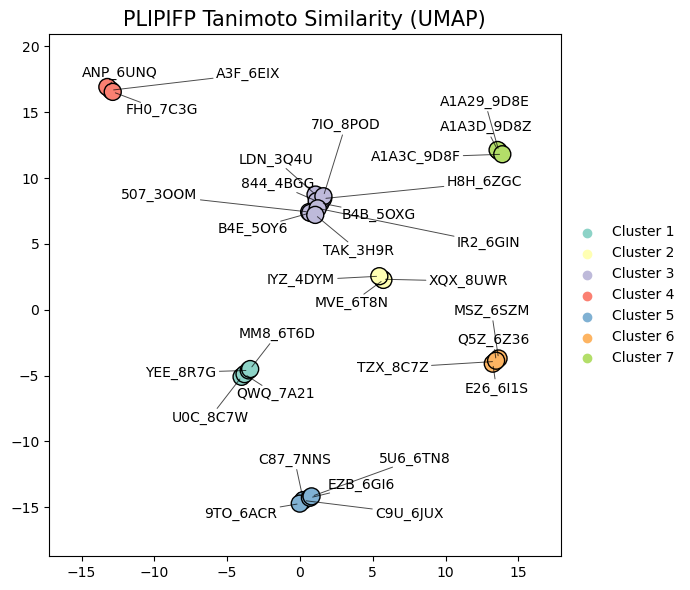

Silhouette score: 0.94022197


In [412]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score

# Assuming your matrix is in a DataFrame called df
reducer = umap.UMAP(metric='precomputed', n_neighbors=2, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(1 - tanimoto)  # 1 - similarity = distance

kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(embedding)

cmap = plt.get_cmap('Set3')  # discrete colormap
colors = cmap(labels)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=150, edgecolor="black")

# Add labels for each molecule (replace molecule_names with your list)
texts = [plt.text(embedding[i, 0], embedding[i, 1], name, fontsize=10, alpha=1)
        for i, name in enumerate(df['name'])]
adjust_text(texts, arrowprops=dict(arrowstyle='-', alpha=0.7, color='black', lw=0.7), force_text=1, force_static=1, prevent_crossings=True, ensure_inside_axes=True, expand=(2,1.5))

for i in range(7):
    plt.scatter([], [], color=cmap(i), label=f'Cluster {i+1}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=10)
plt.title('PLIPIFP Tanimoto Similarity (UMAP)', fontsize=15)
plt.xlim(embedding[:, 0].min() - 4, embedding[:, 0].max() + 4)
plt.ylim(embedding[:, 1].min() - 4, embedding[:, 1].max() + 4)
plt.tight_layout()
plt.savefig("../Results/images/PLIPIFP clusters UMAP (no Vina).png", dpi=300)
plt.show()

score = silhouette_score(embedding, labels)
print(f'Silhouette score:', score)

In [413]:
df_clusters = df.copy()
df_clusters['cluster'] = labels
df_clusters['cluster'] = df_clusters['cluster'] + 1  # make sure all clusters are +1 to lign up with the UMAP plot
df_clusters = df_clusters.drop(columns=['morgan'])

# filter cluster column to only show 1 and 5
#df_clusters = df_clusters[df_clusters['cluster'].isin([1])].reset_index(drop=True)
PandasTools.AddMoleculeColumnToFrame(frame=df_clusters, smilesCol='smiles')
#save the dataframe to a CSV file
df_clusters.to_csv("../Data/docs/11.PLIPIFP_clusters.csv", index=False)
df_clusters.head()

,name,smiles,source,ROMol,hbondd_HIS_268_A,hydroph_PHE_267_A,hydroph_LEU_328_A,hydroph_ASP_339_A,hydroph_LYS_196_A,hydroph_VAL_204_A,...,hbonda_SER_272_A,saltbridge_GLU_230_A,hbondd_THR_265_A,hbonda_ASP_321_A,hbonda_ARG_198_A,hbondd_ARG_200_A,hbondd_LYS_217_A,saltbridge_GLU_194_A,hydroph_GLU_194_A,cluster
0,B4B_5OXG,c1cc(-c2cnn3cc(-c4ccc(N5CCNCC5)cc4)cnc23)c2ccc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x31d2a7ae0>,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,3
1,C9U_6JUX,CCn1cc(-c2ccnc(Nc3ccc(N4CCNCC4)cc3)n2)c(-c2ccc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x32698cd60>,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,5
2,H8H_6ZGC,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x32698d380>,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,3
3,XQX_8UWR,O=C(C1CC1)N1CCN(c2ccnn3cc(-c4ccc(N5CCNCC5)cc4)...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x32698cdd0>,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,2
4,LDN_3Q4U,c1ccc2c(-c3cnn4cc(-c5ccc(N6CCNCC6)cc5)cnc34)cc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x32698d7e0>,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,3
